In [ ]:
#!pip uninstall keras keras-bert tensorflow -y
!pip install tensorflow==2.12.0 keras==2.12.0 keras-bert==0.86.0

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 14.2

In [ ]:
!pip show tensorflow
!pip show keras
!pip show keras-bert

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras
Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/PBL6/Data/"

In [ ]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [ ]:
import os
import codecs
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.optimizers import Adam  # Sử dụng Adam thay vì RAdam
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from sklearn.model_selection import train_test_split

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LR = 1e-5

In [ ]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [ ]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    trainable=True,
    seq_len=SEQ_LEN,
    output_layer_num=4
)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [ ]:
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [ ]:
from keras_bert.layers import Extract
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import Dropout

In [ ]:
inputs = model.inputs[:2]
newout = Extract(index=0)(model.output)
newout = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(newout)
newout = tf.keras.layers.Dropout(0.5)(newout)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01))(newout)
model = tf.keras.models.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=path+'model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.load_weights(path+'cp2_accuracy_bert_base.h5')

In [ ]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
        ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
        indices.append(ids)

    indices = np.array(indices)  # Chuyển đổi thành numpy array
    return [indices, np.zeros_like(indices)], np.array(sentiments)


In [ ]:
import pickle
import pandas as pd
df_train = pd.read_csv(path+"train.csv")
df_train = df_train.dropna()
data_train = df_train.review.to_list()
label_train = df_train.label.to_list()

df_val = pd.read_csv(path+"val.csv")
df_val = df_val.dropna()
data_valid = df_val.review.to_list()
label_valid = df_val.label.to_list()

In [ ]:
X_train,Y_train = load_data(data_train,label_train)
X_valid,Y_valid = load_data(data_valid,label_valid)

(34646, 256)
(34646,)
(6114, 256)
(6114,)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 128, 768),  91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 128, 768)     1536        ['Input-Segment[0][0]']    

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint(path+'cp2_loss_bert_base.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(path+'cp2_accuracy_bert_base.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1, checkpoint2]

In [ ]:
hist = model.fit(X_train,Y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose = 1,
          validation_data=(X_valid,Y_valid),
          callbacks=callbacks_list)

Epoch 1/15
208/208 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9976
Epoch 1: val_loss improved from inf to 0.33013, saving model to /content/drive/MyDrive/PBL6/Data/cp2_loss_bert_base.h5

Epoch 1: val_accuracy improved from -inf to 0.97115, saving model to /content/drive/MyDrive/PBL6/Data/cp2_accuracy_bert_base.h5
208/208 [==============================] - 651s 3s/step - loss: 0.1916 - accuracy: 0.9976 - val_loss: 0.3301 - val_accuracy: 0.9712
Epoch 2/15
208/208 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.33013

Epoch 2: val_accuracy improved from 0.97115 to 0.97356, saving model to /content/drive/MyDrive/PBL6/Data/cp2_accuracy_bert_base.h5
208/208 [==============================] - 618s 3s/step - loss: 0.1563 - accuracy: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9736
Epoch 3/15
208/208 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9991
Epoch 3: val_loss imp

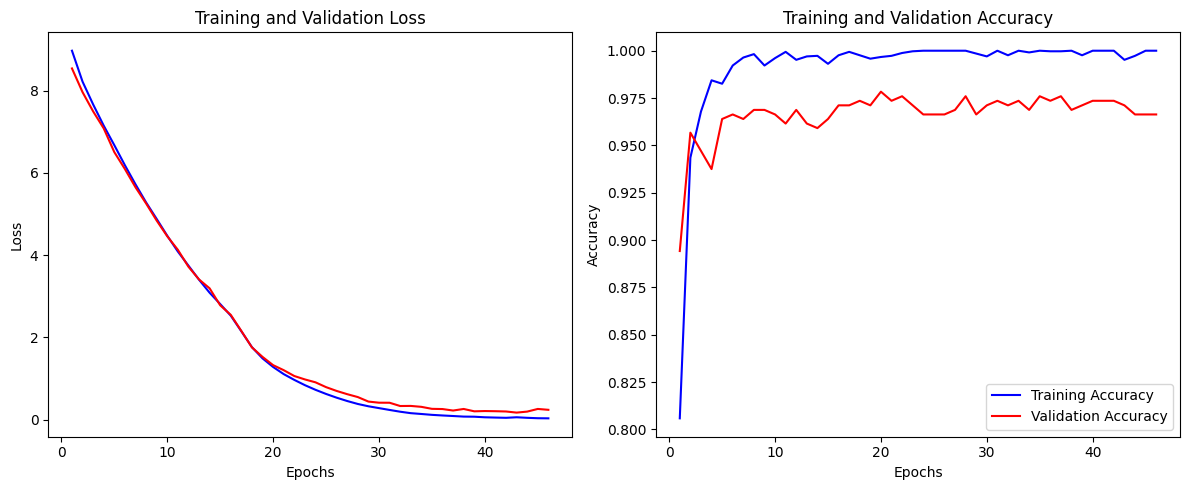

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Tải lại lịch sử huấn luyện đã lưu
with open(path+'combined_new_training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Vẽ biểu đồ Loss và Accuracy
epochs = range(1, len(history['loss']) + 1)

# Vẽ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


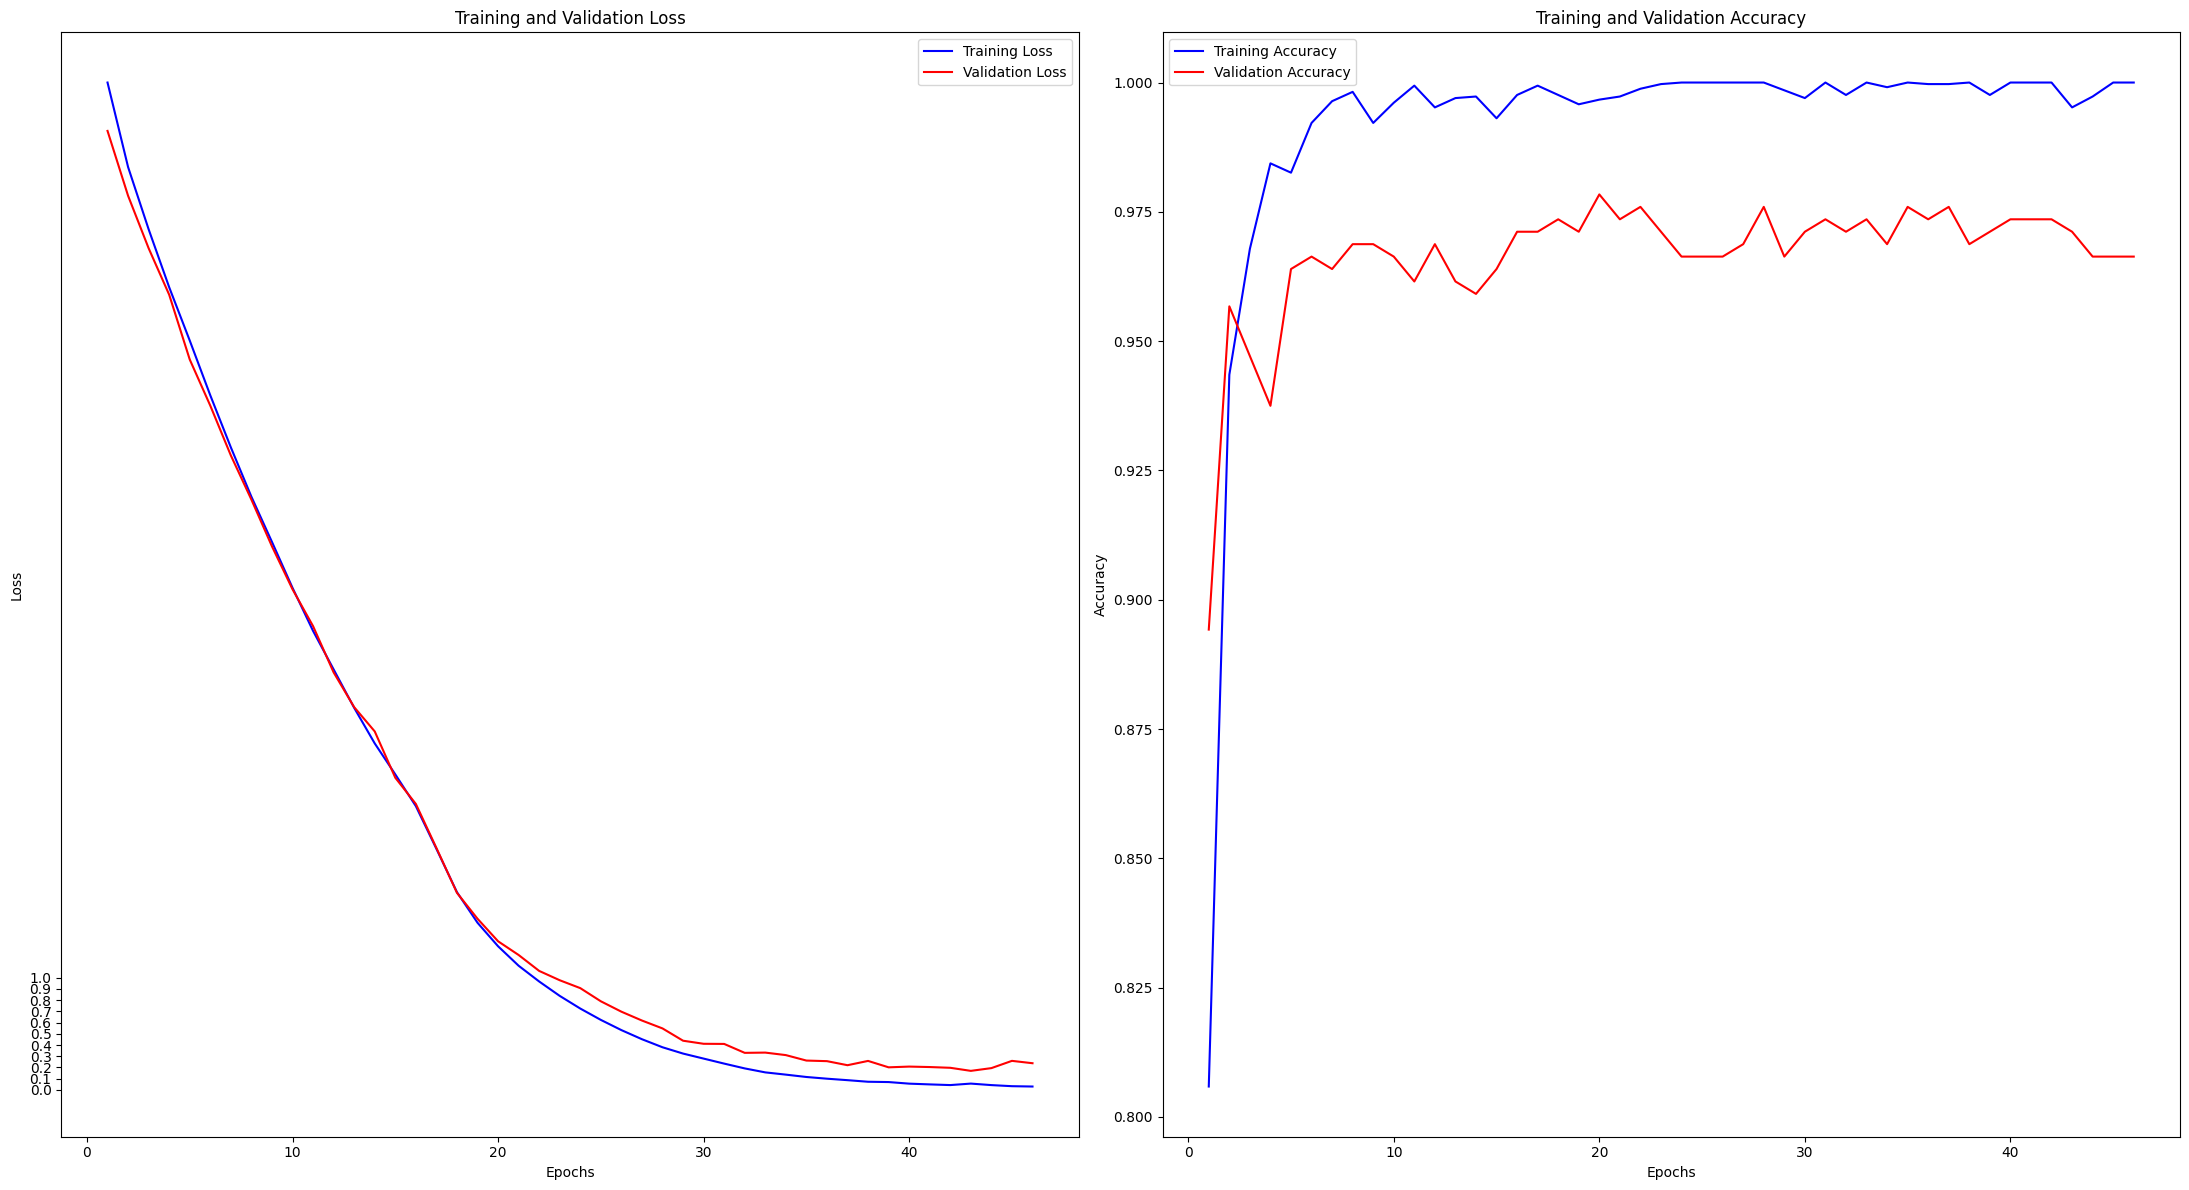

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Tải lại lịch sử huấn luyện đã lưu
with open(path+'combined_new_training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Vẽ biểu đồ Loss và Accuracy
epochs = range(1, len(history['loss']) + 1)

# Vẽ Loss
plt.figure(figsize=(22, 12))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Thêm 10 đốt từ 0 đến 1 cho trục y của Loss
plt.yticks([i * 0.1 for i in range(11)])  # Tạo các dấu vạch từ 0 đến 1 với bước nhảy là 0.1
plt.legend()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


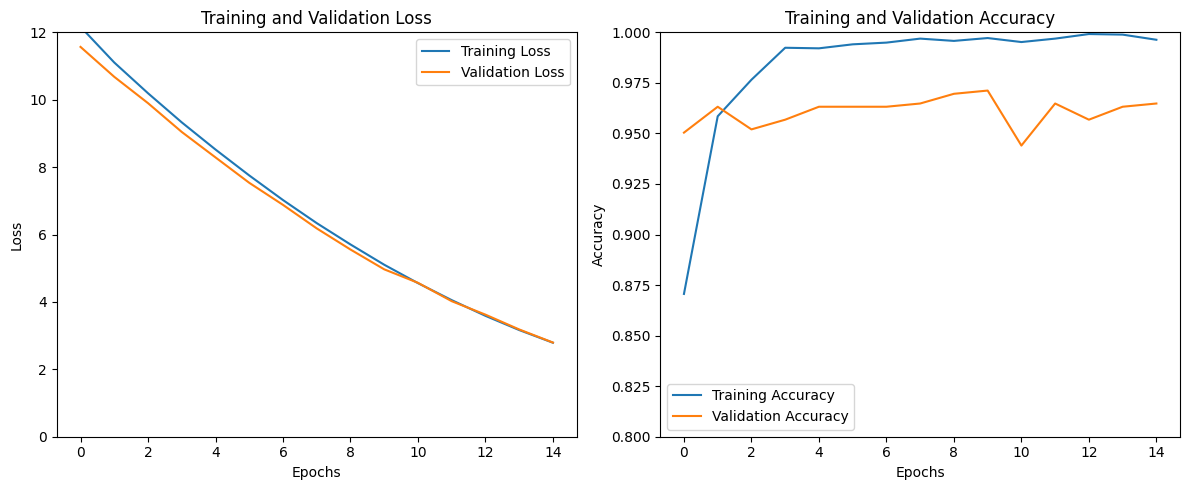

In [ ]:
combined_history = {}
for key in hist.history.keys():
    combined_history[key] = hist.history[key] + hist2.history[key]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(combined_history['loss'], label='Training Loss')
ax[0].plot(combined_history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 12.0)
ax[0].legend()

if 'accuracy' in combined_history:
    ax[1].plot(combined_history['accuracy'], label='Training Accuracy')
    ax[1].plot(combined_history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0.8, 1.0)
    ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save(path+'model_bert_base_final.h5')

In [ ]:
from tensorflow.keras.models import load_model
from keras_bert import get_custom_objects
model = load_model(path + 'model_bert_base_final.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
#@title test.csv
test = pd.read_csv(path+'test.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
y_pred = np.round(model.predict(X_test))
loss, _ = model.evaluate(X_test, Y_test, verbose=0)

14/14 [==============================] - 176s 12s/step


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import accuracy_score

# Tính các chỉ số đo lường
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

# In kết quả
print("Loss:", loss)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Loss: 0.22021397948265076
Precision: 0.95
Recall: 0.9743589743589743
F1 Score: 0.9620253164556962
Accuracy: 0.9569377990430622


In [ ]:
# Tạo DataFrame với các cột review, label thật, và label dự đoán
result_df = pd.DataFrame({
    'review': data_test,
    'label': label_test,
    'predicted_label': y_pred.flatten()  # Flatten nếu y_pred là mảng nhiều chiều
})

# Xuất ra file CSV với mã hóa utf-8-sig
result_df.to_csv('result.csv', index=False, encoding='utf-8-sig')

print("File kết quả đã được lưu thành công!")

File kết quả đã được lưu thành công!


In [ ]:
#@title datanew.csv
test = pd.read_csv(path+'test_remove_sw_no_accent.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [ ]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()

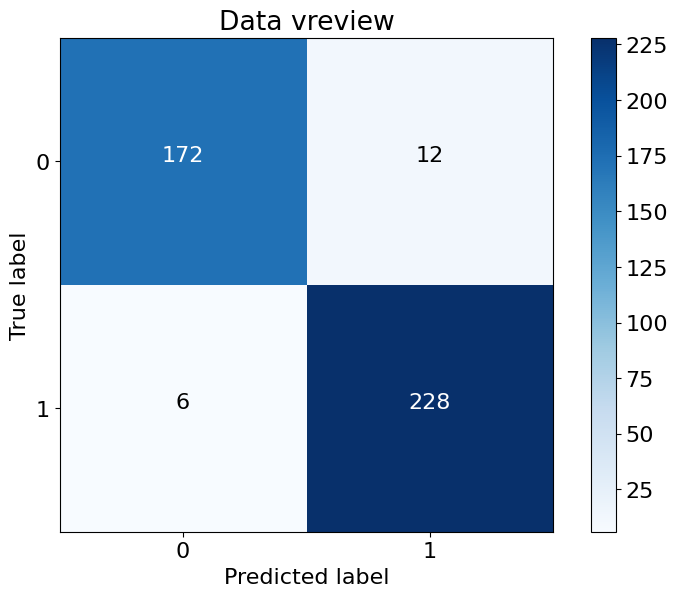

In [ ]:
plot_confusion_matrix(cn,title='Data vreview',normalize=False,target_names=labels,path_file=path+'bert_base_vreview_cm.svg')

In [ ]:
for i in range(1000):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[0.] 1
da di han ngay mua gio roi moi chup feedback lai chan minh di nhung thay co ban bao co be nen lay vua positive in luon di luc bi negative ti vao got nhung minh thay da so giay nao moi di cung the so voi gia la qua dep positive roi
[0.] 1
phí giao hàng quá đắt
[1.] 0
chả có hộp hiếc đàng_hoàng gì có mỗi cây_son tưởng đóng_hộp đẹp positive lắm
[1.] 0
thoi gian giao hang rat nhanh dung ngua negative voi len mun
[1.] 0
chua hai long positive voi san pham
[0.] 1
không hổ_danh là đầu_đàn của android thích positive nhất dòng không của ss
[1.] 0
thật_sự là bị negative rảnh tiền tết quá nên mới mua quyển này đọc được positive một phần ba quyển thật_sự không muốn đọc tiếp nữa ngoài bìa có một câu nói khiến tôi rất tâm_đắc nên cứ nghĩ là truyện sẽ rất hay ai_ngờ lại làm tôi thất_vọng negative cách viết thật_sự quá chán negative hay có những câu mang tính triết_lý nhưng lại không hề triết_lý tí nào kiểu dùng từ hoa_mĩ một_cách tuỳ_tiện vậy tạm không xét đến lời_văn tôi chỉ muốn hỏi tại_sao 